#### 타이타닉 생존자 예측 예제(LSTM)

In [91]:
# 사전 라이브러리 설치(XAI용, : 실현가능한 AI) : pip install sharp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # 성능이 안좋아지기 시작하면 멈추게 함
from sklearn.impute import SimpleImputer    # 결측치를 처리하는데 사용 / 트레인 데이터 평균값을 미리 계산하는 fillna와 비슷(mean해서 평균값을 집어넣던지 0을 집어넣는 것)
from sklearn.preprocessing import LabelEncoder    #범주형 데이터를 숫자형 데이터로 변환하는 데 사용
import shap #샵 # feature importance와 유사 (LSTM에 사용) xai 도구 중 하나임 => explain ai = 설명가능한 ai

In [92]:
# 1. 데이터 로드 및 전처리
train_df = pd.read_csv("dataset/train_titanic.csv")
test_df = pd.read_csv("dataset/test_titanic.csv")

In [93]:
# 데이터 확인
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [94]:
# 결측치 확인
print("Train 데이터 결측치 확인:")
print(train_df.isnull().sum())
print("\nTest 데이터 결측치 확인:") # 테스트 데이터도 잘 볼 것
print(test_df.isnull().sum())

Train 데이터 결측치 확인:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          688
Embarked         2
dtype: int64

Test 데이터 결측치 확인:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [95]:
# 불필요한 컬럼 제거 (원핫 인코딩 없이도 잘 작동하도록) # 필요없는 것 중요하지 않은 것은 제거 drop
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [96]:
# Label Encoding (Sex 컬럼)
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])  # train 데이터 기준으로 transform
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [97]:
# Embarked 컬럼 처리 (최빈값으로 채우기) 배를 탔던 지점 / 최빈값 : 최고로 빈도수가 높게 나오는 값  - mode!! 사용
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [98]:
# Label Encoding (Embarked 컬럼) 
le_embarked = LabelEncoder()
train_df['Embarked'] = le_embarked.fit_transform(train_df['Embarked'])
test_df['Embarked'] = le_embarked.transform(test_df['Embarked']) # train 데이터 기준으로 transform

In [99]:
# Age 컬럼 결측치 처리 (평균으로 채우기) imputer 중간값 train된 것들의 mean값
imputer = SimpleImputer(strategy='mean')
train_df['Age'] = imputer.fit_transform(train_df[['Age']])
test_df['Age'] = imputer.transform(test_df[['Age']])

# Fare 컬럼 결측치 처리 (평균으로 채우기)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean()) # test 데이터에만 Fare 결측치 존재

In [100]:
# 전처리 후 데이터 확인
print("전처리 후 데이터 형태:")
print("Train 데이터:", train_df.shape)
print("Test 데이터:", test_df.shape)

전처리 후 데이터 형태:
Train 데이터: (891, 8)
Test 데이터: (418, 7)


In [101]:
# 데이터 컬럼 확인
print("\nTrain 데이터 컬럼:", train_df.columns.tolist())
print("Test 데이터 컬럼:", test_df.columns.tolist())


Train 데이터 컬럼: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Test 데이터 컬럼: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [102]:
# 스케일링 (MinMaxScaler)
scaler = MinMaxScaler()
X = train_df.drop('Survived', axis=1) # Survived 빼버림
y = train_df['Survived']

In [103]:
# 피쳐 수가 몇 개인지 확인
n_features = X.shape[1]
print(f"피처 수: {n_features}")

피처 수: 7


In [104]:
X = scaler.fit_transform(X)
test_data = scaler.transform(test_df)

# 특성 이름 저장 (SHAP 시각화에 사용)
feature_names = train_df.drop('Survived', axis=1).columns.tolist()

# train, validation!!!! set 분리 20% validation 보완을 시킨 후 테스트 데이터를 나눔
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 형태 확인 / step 하나씩 하나씩 / reshape 차원변경
print(f"X_train 형태(reshape 전): {X_train.shape}") # 8
print(f"X_val 형태(reshape 전): {X_val.shape}")     # 2
print(f"test_data 형태(reshape 전): {test_data.shape}")


X_train 형태(reshape 전): (712, 7)
X_val 형태(reshape 전): (179, 7)
test_data 형태(reshape 전): (418, 7)


In [105]:
# LSTM 입력을 위한 reshape (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, n_features)
X_val = X_val.reshape(X_val.shape[0], 1, n_features)
test_data = test_data.reshape(test_data.shape[0], 1, n_features)

In [106]:
# reshape 후 형태 확인 / 7 스텝 추가됨
print(f"X_train 형태(reshape 후): {X_train.shape}")
print(f"X_ 형태(reshape 후): {X_val.shape}")
print(f"test_data 형태(reshape 후): {test_data.shape}")

X_train 형태(reshape 후): (712, 1, 7)
X_ 형태(reshape 후): (179, 1, 7)
test_data 형태(reshape 후): (418, 1, 7)


In [107]:
# 2. LSTM 모델 구축 - 인공신경망 Sequential 추가 / 64, 32 뉴런 수
model = Sequential()
model.add(LSTM(64, input_shape=(1, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
# 모델 구조 확인 - 인공 신경망
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 64)          │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # 10번의 에폭 동안 개선이 없으면 학습 중단 - 임의값 변경 가능
    restore_best_weights=True,    #  가장 좋은 성능을 보였던 모델의 가중치(weights)를 복원
    verbose=1             # 중단 시 메시지 출력
)

In [110]:
# 3. 모델 훈련 - verbose=1로 설정하여 진행상황 확인
epochs = 100
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1             # 훈련 진행상황 출력
)

Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6175 - loss: 0.6861 - val_accuracy: 0.5866 - val_loss: 0.6689
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6263 - loss: 0.6551 - val_accuracy: 0.5866 - val_loss: 0.6364
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6156 - loss: 0.6186 - val_accuracy: 0.5866 - val_loss: 0.6120
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6329 - loss: 0.5850 - val_accuracy: 0.5922 - val_loss: 0.5871
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6122 - loss: 0.5913 - val_accuracy: 0.6983 - val_loss: 0.5619
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7147 - loss: 0.5545 - val_accuracy: 0.7486 - val_loss: 0.5389
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7819 - loss: 0.5231 - val_accuracy: 0.7542 - val_loss: 0.5180
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8030 - loss: 0.4807 - val_accuracy: 0.7821 - val_loss: 0.

In [111]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(history.history['loss'])
print(f"학습이 {actual_epochs}번째 에폭에서 완료되었습니다.")

학습이 56번째 에폭에서 완료되었습니다.


In [112]:
# 예측 및 평가
# Validation set 평가
y_pred_val_proba = model.predict(X_val, verbose=0)
y_pred_val = (y_pred_val_proba > 0.5).astype(int)

# 테스트 데이터 예측
y_pred_proba = model.predict(test_data, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# ROC Curve 및 AUC 계산 (Validation set)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_proba)
roc_auc = auc(fpr, tpr)

# Confusion Matrix (Validation set)
cm = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (Validation Set):\n", cm)

Confusion Matrix (Validation Set):
 [[91 14]
 [23 51]]


In [114]:
# Classification Report (Validation set)
print("\nClassification Report (Validation Set)\n", classification_report(y_val, y_pred_val))


Classification Report (Validation Set)
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       105
           1       0.78      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



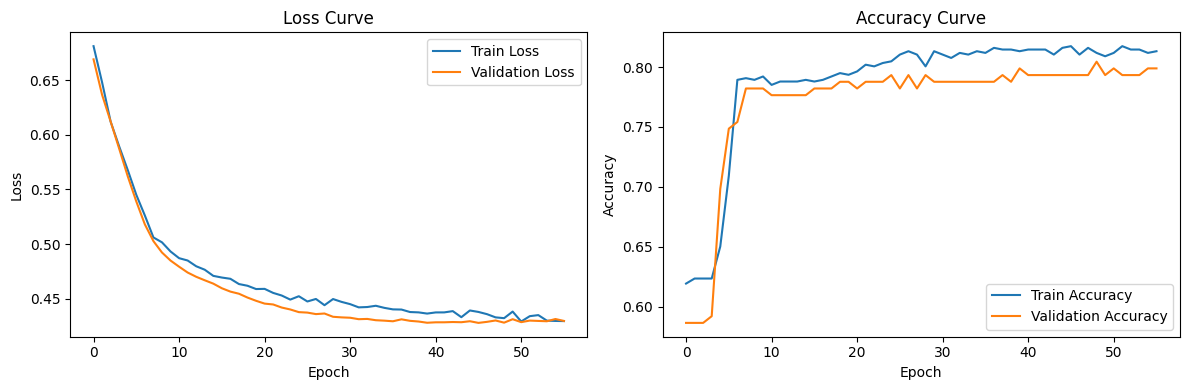

In [115]:
# 결과 시각화 및 통계 분석

# 학습 곡선 시각화(loss, accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

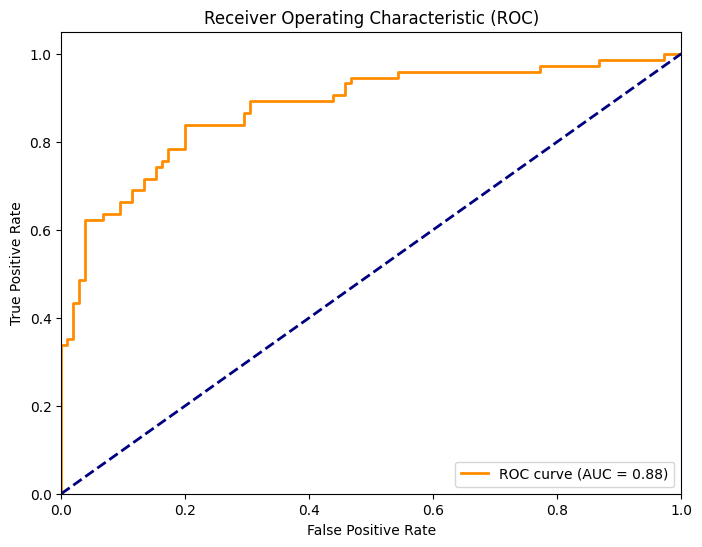

In [116]:
# ROC Curve 시각화 (Validation set)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

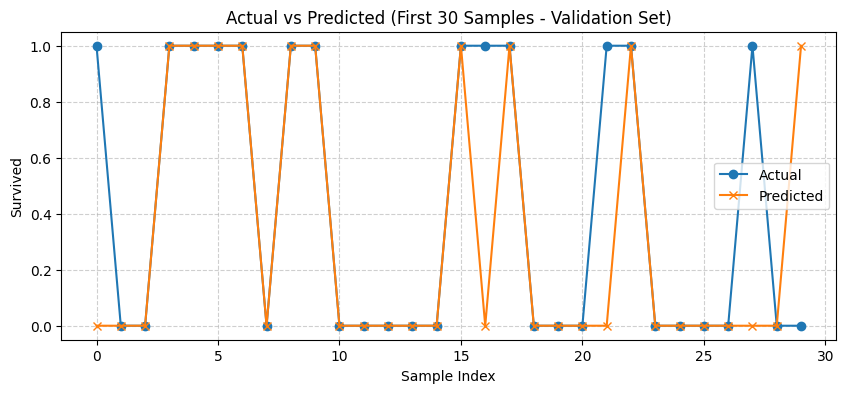

In [117]:
# 실제값 vs 예측값 시각화 (Validation set - 처음 30개 샘플)
plt.figure(figsize=(10, 4))
plt.plot(y_val[:30].values, label='Actual', marker='o')
plt.plot(y_pred_val[:30].flatten(), label='Predicted', marker='x')  # flatten() 추가
plt.title('Actual vs Predicted (First 30 Samples - Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Survived')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
plt.show()

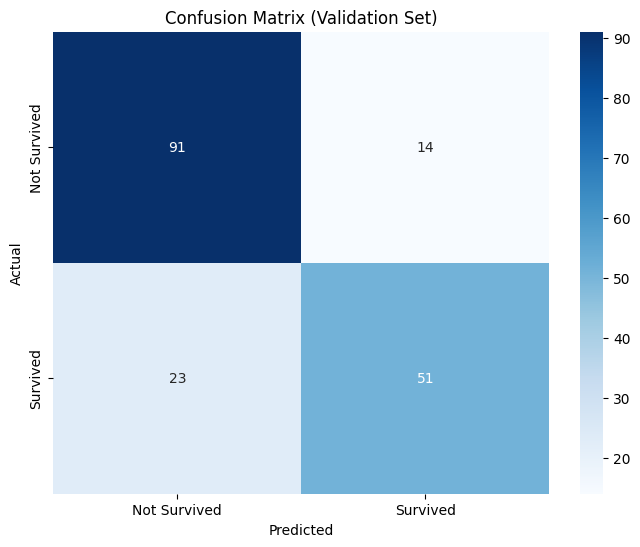

In [118]:
# Confusion Matrix 시각화 (Validation set)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [120]:
# 6. 예측 결과 저장 (개선된 버전)
# test_titanic.csv에서 직접 PassengerId 가져오기
original_test_df = pd.read_csv("dataset/test_titanic.csv")
passenger_ids = original_test_df['PassengerId']

In [121]:
# 예측 결과와 PassengerId를 합쳐 새로운 DataFrame 생성
forecast_results = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_pred.flatten()  # flatten()으로 1차원 배열로 변환
})

In [122]:
# 결과 확인
print("예측 결과 (처음 5개 샘플):")
print(forecast_results.head())

예측 결과 (처음 5개 샘플):
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


In [123]:
# 결과를 CSV 파일로 저장
forecast_results.to_csv('dataset/forecast_titanic.csv', index=False)
print("Survived 예측 결과가 dataset/forecast_titanic.csv 파일로 저장되었습니다.")

Survived 예측 결과가 dataset/forecast_titanic.csv 파일로 저장되었습니다.


In [124]:
# 7. 모델 저장 (선택 사항)
model.save('model/titanic_lstm_model.h5')
print("모델이 'titanic_lstm_model.h5' 파일로 저장되었습니다.")

모델이 'titanic_lstm_model.h5' 파일로 저장되었습니다.
